In [1]:
import os

import numpy as np
import pandas as pd

import math
from natsort import natsorted

from matplotlib import colors
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.lines import Line2D
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap

from utils.utility_functions import categorical_cmap

In [2]:
# Paths and inputs
root = '/Volumes/T7 Shield/cylinter_input/clean_quant/output_3d_v2/'
df = pd.read_parquet(os.path.join(os.getcwd(), 'input/CRC-097_clean_cylinter_pca.parquet'))

out = os.path.join(os.getcwd(), 'output/3d_umap_animation')
if not os.path.exists(out):
    os.makedirs(out)

In [3]:
# Reproduce index at point of embedding, then merge saved embedding with dataframe
groups = df.groupby('Sample')
sample_weights = pd.DataFrame({'weights': 1 / (groups.size() * len(groups))})
weights = pd.merge(df[['Sample']], sample_weights,left_on='Sample', right_index=True)
df = df.sample(frac=1.0, replace=False, weights=weights['weights'], random_state=5, axis=0)
embedding = np.load(os.path.join(root, 'clustering/final/embedding.npy'))
df['emb1'] = embedding[:, 0]
df['emb2'] = embedding[:, 1]
df['emb3'] = embedding[:, 2]

In [4]:
# GATING CODE
# read soft gates
# gate = pd.read_csv('/Volumes/T7 Shield/cylinter_input/' +
#                    'clean_quant/gating.csv')

# work on a copy of needed columns
# gate = gate[['CellID', 'Label']].copy()

# isolate + and - populations
# yes_gate = df[df['CellID'].isin(gate['CellID'])]
# no_gate = df[~df['CellID'].isin(gate['CellID'])]

# sample the negative population
# no_gate = no_gate.sample(n=len(gate), random_state=1)

# append to positive population
# df = no_gate.append(yes_gate)

# append CyLinter dataframe with gate calls, row-wise
# df = df.merge(gate, how='left', on='CellID')

# fill NANs
# df['Label'].fillna(value='Pop0', inplace=True)

# sort by gate label column
# df['Label'] = pd.Categorical(
#     df['Label'], ordered=True,
#     categories=natsorted(df['Label'].unique())
#     )

# df = df.sort_values('Label')

In [5]:
# Read Leiden cluster labels
leiden_labels = pd.read_csv(os.path.join(os.getcwd(), 'input/CRC-097_leiden.csv'))

# Read HDBSCAN cluster labels
hdbscan_labels = pd.read_csv(os.path.join(os.getcwd(), 'input/CRC-097_hdbscan.csv'))

Leiden plot


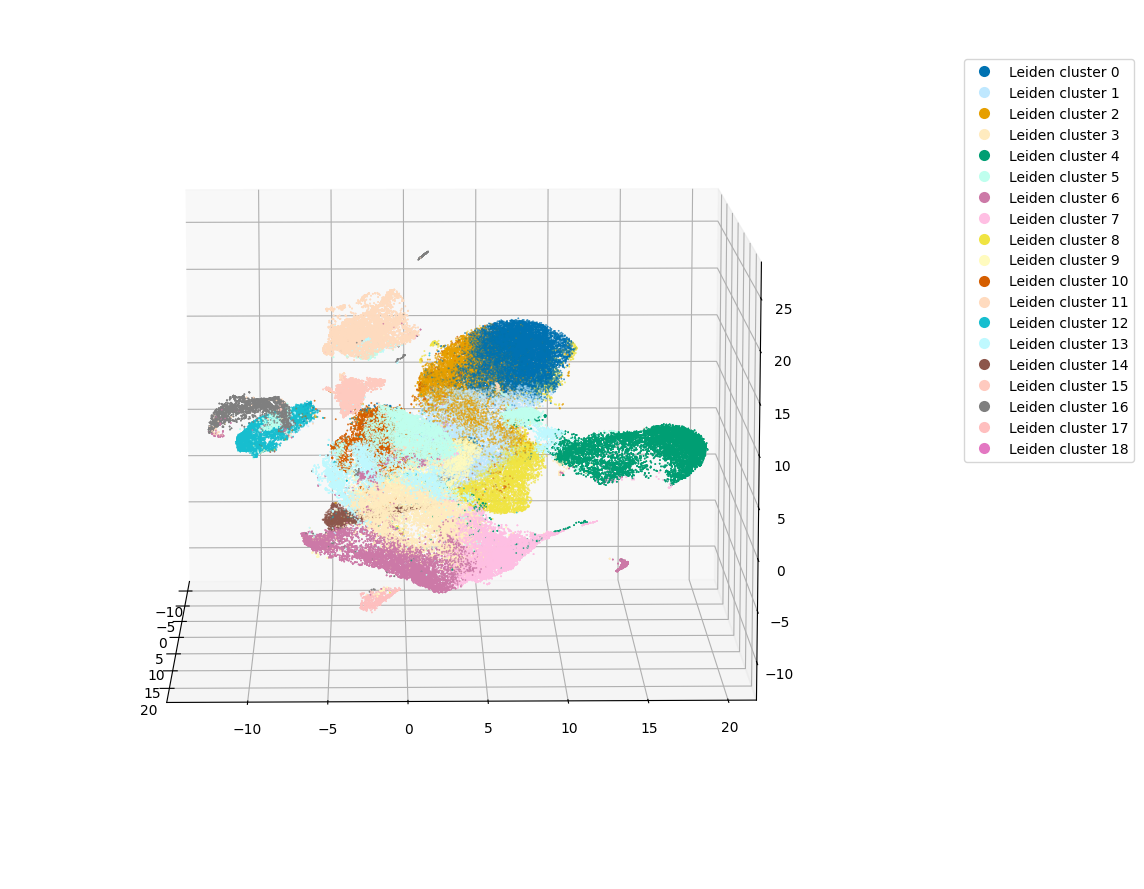

HDBSCAN plot


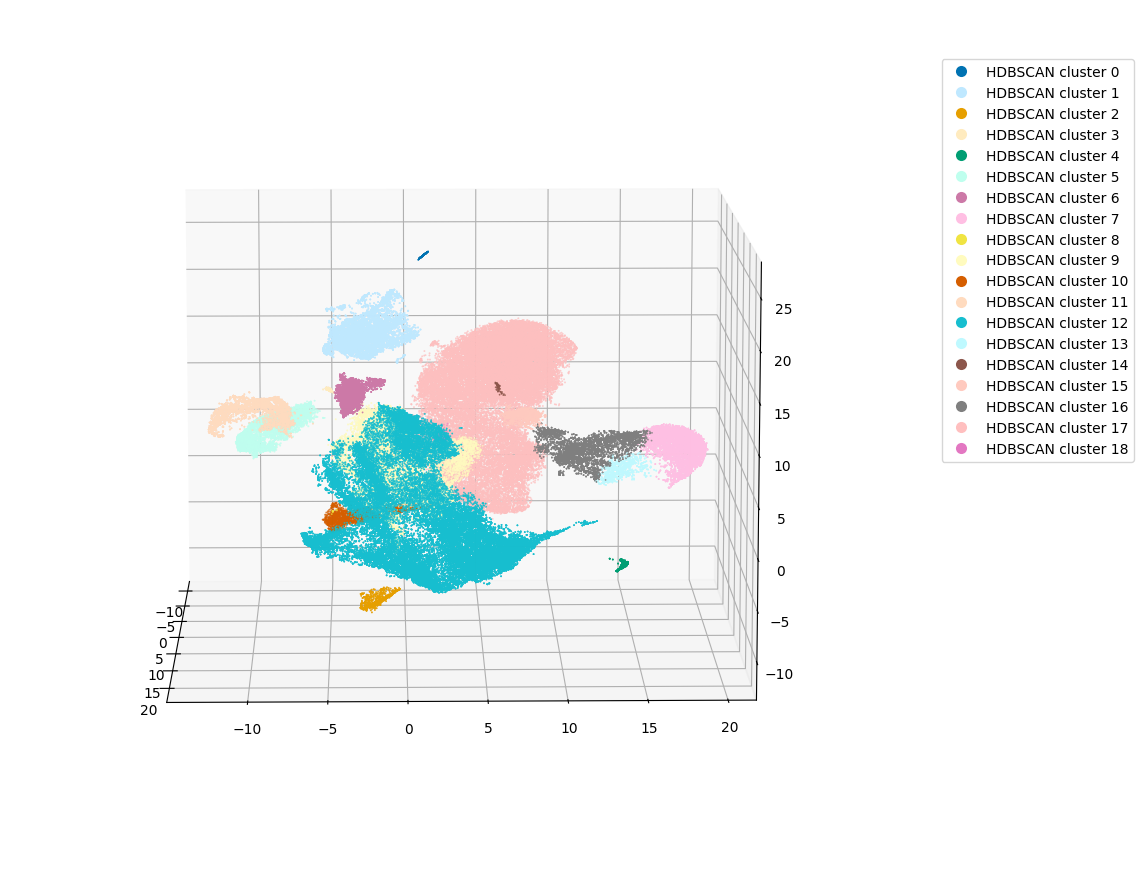

In [6]:
# Generate rotating plots
plt.rcParams['figure.figsize'] = (13, 9)

for name, labels in zip(['Leiden', 'HDBSCAN'], [leiden_labels, hdbscan_labels]):

    print (f'{name} plot')

    labels.columns = ['CellID', 'cluster']
    
    # Ensure CELL ID column is int dtype
    labels['CellID'] = labels['CellID'].astype(int)

    # Ensure cluster column is int dtype
    labels['cluster'] = labels['cluster'].astype(int)
    
    # Append cluster labels to CyLinter dataframe
    df_labeled = df.merge(labels, how='inner', on='CellID')
    
    # Use a subset of cells for plotting; shuffle index for homogenous z-order
    df_labeled = df_labeled.sample(frac=0.1, random_state=1)

    # Remove unclustered cells in the case of HDBSCAN
    df_labeled = df_labeled[df_labeled['cluster'] != -1]
    
    df_labeled.reset_index(drop=True, inplace=True)

    # PLOT
    fig = plt.figure()
    ax = plt.axes(projection='3d', computed_zorder=False)

    # build cmap
    cmap = categorical_cmap(
        numUniqueSamples=len(df_labeled['cluster'].unique()),
        numCatagories=10, cmap='tab10', continuous=False
    )

    if df_labeled['cluster'].unique().min() == -1:
        # make black the first color to specify
        # cluster outliers (i.e. cluster -1 cells)
        cmap = ListedColormap(
            np.insert(
                arr=cmap.colors, obj=0, values=[0.0, 0.0, 0.0], axis=0)
        )

        # Trim qualitative cmap to number of unique samples
        cmap = ListedColormap(cmap.colors[:-1])

    sample_dict = dict(
        zip(
            natsorted(df_labeled['cluster'].unique()),
            list(range(len(df_labeled['cluster'].unique()))))
    )

    c = [sample_dict[i] for i in df_labeled['cluster']]

    def init():
        ax.scatter(
            df_labeled['emb1'],
            df_labeled['emb2'],
            df_labeled['emb3'],
            c=c,
            cmap=cmap,
            s=150000 / len(df_labeled),
            ec=['k' for i in df_labeled['cluster']],
            linewidth=0.0
        )

        ax.axis('auto')
        ax.tick_params(labelsize=10)
        ax.grid(True)

        legend_elements = []
        for e, i in enumerate(natsorted(df_labeled['cluster'].unique())):

            legend_elements.append(
                Line2D([0], [0], marker='o',
                       color='none',
                       label=f'{name} cluster {i}',
                       markerfacecolor=cmap.colors[e],
                       markeredgecolor='none',
                       lw=0.001, markersize=8)
            )

        cluster_lgd = ax.legend(
            handles=legend_elements, prop={'size': 10}, bbox_to_anchor=[1.3, 0.95]
        )
        plt.tight_layout()
        return fig,

    def animate(i):
        ax.view_init(elev=10., azim=i)
        return fig,

    anim = animation.FuncAnimation(
        fig, animate, init_func=init,
        frames=360, interval=20, blit=True)

    anim.save(
        os.path.join(out, f'{name}_400dpi.mp4'),
        dpi=400, fps=30, extra_args=['-vcodec', 'libx264'])
    plt.show()
    plt.close('all')